In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

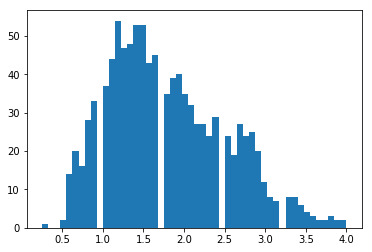

In [8]:
plt.hist(phone_df.age.values, bins = 50);

In [9]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


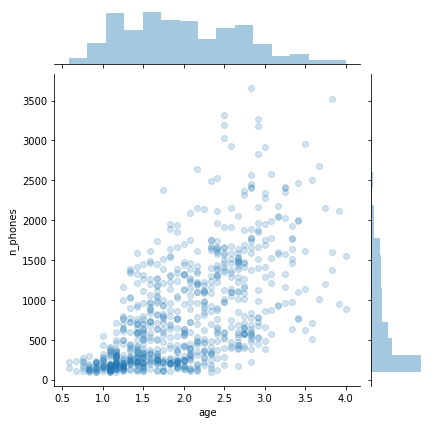

In [10]:
import seaborn as sns
sns.jointplot("age", "n_phones", data=phone_df[phone_df.n_phones > 100], alpha=0.2)

In [11]:
np.median(phone_df.n_phones)

306.0

## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [12]:
from childes_mi.information_theory import mutual_information as mi

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.expected_mutual_info_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Test run

In [13]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [14]:
distances = np.arange(1,101)

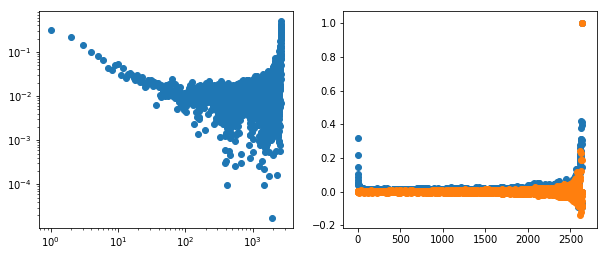

KeyboardInterrupt: 

In [22]:
nex = 5
MI_DF_long = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        "age",
        "dataset",
        "xml_loc",
        "n_phones",  
        "phones_list"
        
    ]
)
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    
    for idx, longest_row in tqdm(cohort_subset.sort_values(by='n_phones', ascending=False)[:nex].iterrows(), total=nex):
        phones_list = ''.join(flatten([i for i in flatten(longest_row.phones) if i is not None]))
        
        
        n_phones = len(phones_list)
        n_unique_phones = len(np.unique(phones_list))
        
        distances = np.arange(1, n_phones - 1)
        (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information([list(phones_list)],  
                                                      distances = distances, 
                                                      mi_estimation="adjusted_mi_sklearn")
        

        
        fig,axs = plt.subplots(ncols=2, figsize = (10,4))
        ax = axs[0]
        ax.scatter(distances, MI-shuff_MI)
        ax.plot(distances, MI-shuff_MI, alpha = 0)
        ax.set_yscale('log')
        ax.set_xscale('log')
        
        ax = axs[1]
        ax.scatter(distances, MI)
        ax.scatter(distances, shuff_MI)
        plt.show()
        
        
        
        MI_DF_long.loc[len(MI_DF_long)] = [
            MI,
            MI_var,
            shuff_MI,
            shuff_MI_var,
            distances,
            age_cohort_low,
            age_cohort_high,
            n_phones,
            n_unique_phones,
            longest_row.age,
            longest_row.dataset,
            longest_row.xml_loc,
            longest_row.n_phones,
            phones_list
            
        ]

In [ ]:
MI_DF_long[:3]

In [ ]:
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = MI_DF_long[MI_DF_long.age_cohort_high == age_cohort_high]
    print(age_cohort_low, age_cohort_high)
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20,15))
    for idxi, (idx, row) in tqdm(enumerate(cohort_subset.iterrows())):
        
        MI = row.MI
        shuff_MI = row.shuff_MI
        
        ax = axs.flatten()[idxi]
        ax.scatter(distances, MI-shuff_MI)
        ax.plot(distances, MI-shuff_MI, alpha = 0)
        
        axmin = np.min((MI-shuff_MI)[(MI-shuff_MI) > 0])
        axmax = np.max((MI-shuff_MI)[(MI-shuff_MI) > 0])
        ax.set_title("{}: {} | {}".format(row.dataset, row.agerow.n_phones))
        ax.set_ylim([axmin, axmax])
        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()